<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/tensorflow_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf

### 0. Data Preparation

In [119]:
tf.random.set_seed(0)
np.random.seed(0)


sample_size = 500
batch_size = 10
sigma_e = 3.0             # true value of parameter error sigma
xs = 100 * np.random.rand(sample_size)
es = np.random.normal(0, sigma_e, sample_size)
ys = 1.0 + 2.0 * xs + es

ds = tf.data.Dataset.from_tensor_slices((xs, ys)).shuffle(buffer_size=sample_size).batch(batch_size)
for x, y in ds.take(1):         # take first batch
    print(x, y)

tf.Tensor(
[94.53015335 42.40889884 42.40322519 84.90383084 43.44166256  2.01075462
 55.20782767 40.71832972 49.04588086 10.20448107], shape=(10,), dtype=float64) tf.Tensor(
[189.93610426  85.85229439  84.8538211  170.60625922  86.47141214
   3.74855637 115.39504027  81.28272318  97.11208653  21.64374268], shape=(10,), dtype=float64)


### 1. Low-Level Implementation

The convergence depends on initial states of w and b, batch_size, learning rate, and loss function (mse or rmse), etc.

In [120]:
w = tf.Variable(tf.random.normal(shape=[1], dtype=tf.float64))      # scaler, shape=[] or shape=[1,]
b = tf.Variable(0,  dtype = tf.float64)          # scaler

epochs = 100
learning_rate = 0.001
ws = []
bs = []
for epoch in tf.range(1,epochs+1):      # for each epoch
  for x, y in ds:           # for each batch
    with tf.GradientTape() as tape:
      y_bar = x*w + b                    # broadcasting
      loss = tf.sqrt(tf.reduce_mean( (y-y_bar)**2 ))
      # loss = tf.reduce_mean( (y-y_bar)**2 )
    # Back propagation to calculate gradient
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # apply_gradients
    w.assign(w - learning_rate * dloss_dw)         # assign, keeps tf.Variable; operator ==> tf.Tensor
    b.assign(b - learning_rate * dloss_db)
    ws.append(w.numpy()[0])
    bs.append(b.numpy())

  if epoch % 20 == 0:
    tf.print('w=', w[0], ' ,b=', b, ' ,mse=', loss)

w= 2.0092433160037424  ,b= 0.083804579058864792  ,mse= 2.5152901410985193
w= 2.0133854164832647  ,b= 0.12503606117564978  ,mse= 3.4116469321528675
w= 1.9745402878296359  ,b= 0.16570829832847597  ,mse= 2.181400506321292
w= 2.0332908978757693  ,b= 0.20492633276977928  ,mse= 1.9839655160821144
w= 1.9998285047327671  ,b= 0.23774513013090734  ,mse= 4.39657509939333


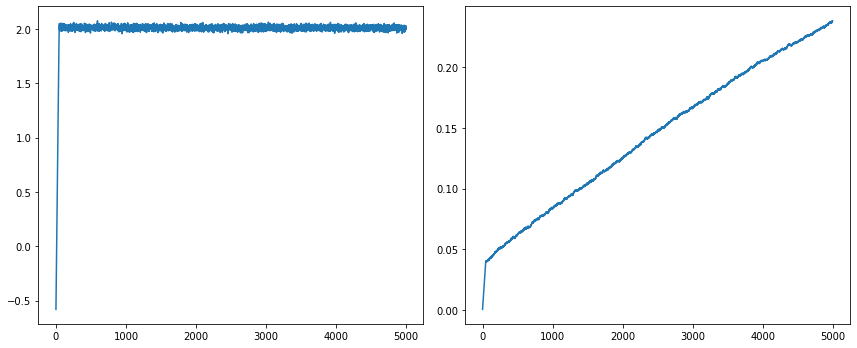

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.tight_layout()
axes[0].plot(ws)
axes[1].plot(bs)

### 2. High-Level Implementation

In [123]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape =(1,)))        # total param # = 2
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [125]:
loss_fn = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.RootMeanSquaredError()])

We can either mix it with low-level api

In [126]:
epochs = 200

for epoch in tf.range(1,epochs+1):      # for each epoch
  loss = tf.constant(0.0)
  for x, y in ds:           # for each batch
    with tf.GradientTape() as tape:
      y_bar = model(y)                # __call__
      loss = loss_fn(tf.reshape(y, [-1]), tf.reshape(y_bar, [-1]))
    # Back propagation to calculate gradient
    grads = tape.gradient(loss, model.variables)
    # apply_gradients
    model.optimizer.apply_gradients(zip(grads, model.variables))
  
  if epoch%20==0:
    tf.print('w=', w, ' ,b=', b, ' ,mse=', loss)

w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 32856.3203
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 6936.47
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 790.176208
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 7.72515583
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 0.698684156
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 1.83272243
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 1.08908737
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 0.85788995
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 0.855531335
w= [1.9998285047327671]  ,b= 0.23774513013090734  ,mse= 0.84222728


Or just call model.fit

In [128]:
tf.keras.backend.clear_session()
model.reset_states()

model.fit(tf.convert_to_tensor(xs), tf.convert_to_tensor(ys), batch_size = 10, epochs = 200, verbose=0) 
tf.print('w=', model.layers[0].kernel, ' b=', model.layers[0].bias)

w= [[1.99535918]]  b= [0.967212737]
